#Initial Setup

In [1]:
from lang_classifier import *
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
def setup():
    """Load the training benchmark training data and split it for train/test"""
    df = load_bench_data()
    X = df.text
    y = df.language
    test_data = load_test_data()
    args = train_test_split(X, y, test_size=0.2, random_state=0)
    # X_train, X_test, y_train, y_test
    
    return df, X, y, test_data, args

In [3]:
df, X, y, test_data, args = setup()  # Load and split the train/test data
X_train, X_test, y_train, y_test = args

####Inspect the test_data dataframe to make sure language and text are properly aligned

In [4]:
test_data

,language,text,guess
item,,,
0,perl,use warnings;\nuse strict;\n\nmy $initial = jo...,NaN
1,clojure,"(defn cf-settings\n ""Setup settings for campf...",NaN
2,clojure,(ns my-cli.core)\n\n(defn -main [& args]\n (p...,NaN
3,clojure,(extend-type String\n Person\n (first-name [...,NaN
4,clojure,(require '[overtone.live :as overtone])\n\n(de...,NaN
5,python,from pkgutil import iter_modules\nfrom subproc...,NaN
6,python,import re\nimport subprocess\n\ndef cmd_keymap...,NaN
7,python,class NoSuchService(Exception):\n def __ini...,NaN
8,python,from collections import namedtuple\nimport fun...,NaN


### Use a generic bag of words/naive bayes classifier pipeline as a baseline

In [5]:
def assess_test_data(pipe):
    test_data['guess'] = pd.DataFrame(pipe.predict(test_data['text']))
    correct = test_data[test_data.language == test_data.guess]
    print('Proportion of test data correctly labeled: {:.3f}'.format(len(correct) / len(test_data)))
    print(test_data[['language', 'guess', 'text']])


In [6]:
spam_pipe = Pipeline([('bag_of_words', CountVectorizer()),
                      ('bayes', MultinomialNB())])
classifier = assess_classifier(spam_pipe, *args)
c = classifier.predict(X)
#print('Guesses: ', c[0:5])
assess_test_data(spam_pipe)

Train score: 0.989, Test score: 0.949
Proportion of test data correctly labeled: 0.727
        language       guess  \
item                           
0           perl        perl   
1        clojure     clojure   
2        clojure     clojure   
3        clojure     clojure   
4        clojure     clojure   
5         python      python   
6         python     clojure   
7         python        ruby   
8         python      python   
9     javascript  javascript   
10    javascript  javascript   
11    javascript     clojure   
12    javascript         php   
13          ruby        ruby   
14          ruby     clojure   
15          ruby        ruby   
16       haskell     haskell   
17       haskell     haskell   
18       haskell     clojure   
19        scheme      scheme   
20        scheme      scheme   
21        scheme      scheme   
22          java        java   
23          java           c   
24         scala       scala   
25         scala       scala   
26           tcl 

#### Inspect the baseline features

In [7]:
cv = CountVectorizer()
ft = cv.fit_transform(X)
print(cv.get_feature_names()[-30:])
spam_pipe = Pipeline([('bag_of_words', cv),
                      ('bayes', MultinomialNB())])
classifier = assess_classifier(spam_pipe, *args)

['zin', 'zip', 'zipwith', 'zipwithindex', 'zipwithm', 'zipwithm_', 'ziv', 'ziv1', 'ziv2', 'zizi', 'zoo', 'zotov', 'zq', 'zr', 'zr1', 'zr2', 'zri', 'zrn', 'zrv', 'zrv1', 'zrv2', 'zrzi', 'zrzr', 'zs', 'zt', 'zu', 'zubach', 'zx', 'zy', 'zz']
Train score: 0.989, Test score: 0.949


###Now try making a limited custom vocabulary to discriminate between languages

In [8]:
cv = CountVectorizer(vocabulary=['}', ')', 'var', 'fn', 'function', 'end', 'defn',
                                 '===', 'lambda']) #, '(define', 'elif'])
ft = cv.fit_transform(X)
print(cv.get_feature_names()[-30:])  
spam_pipe = Pipeline([('bag_of_words', cv),
                      ('bayes', MultinomialNB())])
classifier = assess_classifier(spam_pipe, *args)
assess_test_data(spam_pipe)

['}', ')', 'var', 'fn', 'function', 'end', 'defn', '===', 'lambda']
Train score: 0.329, Test score: 0.436
Proportion of test data correctly labeled: 0.485
        language       guess  \
item                           
0           perl        ruby   
1        clojure     clojure   
2        clojure     clojure   
3        clojure        ruby   
4        clojure     clojure   
5         python        ruby   
6         python        ruby   
7         python        ruby   
8         python      python   
9     javascript         php   
10    javascript  javascript   
11    javascript  javascript   
12    javascript  javascript   
13          ruby        ruby   
14          ruby        ruby   
15          ruby        ruby   
16       haskell        ruby   
17       haskell        ruby   
18       haskell        ruby   
19        scheme      scheme   
20        scheme      scheme   
21        scheme      scheme   
22          java        ruby   
23          java        ruby   
24         sc

Vocabulary|Results
----------|-------
} | Train score: 0.122, Test score: 0.137
}, ) | Train score: 0.122, Test score: 0.137
}, ), var | Train score: 0.161, Test score: 0.179
}, ), var, fn | Train score: 0.195, Test score: 0.248
}, ), var, fn, function| Train score: 0.287, Test score: 0.308
}, ), var, fn, function, end | Train score: 0.278, Test score: 0.325
}, ), var, fn, function, end, defn | Train score: 0.302, Test score: 0.359
}, ), var, fn, function, end, defn, === | Train score: 0.300, Test score: 0.368
}, ), var, fn, function, end, defn, ===, lambda | Train score: 0.334, Test score: 0.427
}, ), var, fn, function, end, defn, ===, lambda | Proportion of test data correctly labeled: 0.485


The above didn't work nearly as well as the automatically-generated vocabulary with thousands of words. Adding new words quickly yielded diminishing returns. Since we want to get above 80% accuracy, it looks like we will need to add our own features.

##Define new features

In [9]:
def longest_run_of_caps_feature(text):
    """Find the longest run of capitol letters and return their length."""
    runs = sorted(re.findall(r"[A-Z]+", text), key=len)
    if runs:
        return len(runs[-1])
    else:
        return 0

In [73]:
def percent_character_feature(char):
    """Return percentage of text that is a particular char compared to total text length."""
    def feature_fn(text):
        chars = text.count(char)
        return chars / len(text)
    return feature_fn

# def percent_characters_feature(char_list):
#     """
#     Return percentage of text for each char/substring in char_list,
#     compared to total text length.
#     """
#     def feature_fn(text):
#         hits = []
#         for char in char_list:
#             hits.append(text.count(char) / len(text))
#         return hits
#     return feature_fn

def count_word_feature(word):
    """Return percentage of text that is a particular char compared to total text length."""
    def feature_fn(text):
        num_words = text.count(word)
        return num_words
    return feature_fn

def longest_line_feature(text):
    lines = re.findall(r'.*?\n', text)
    if not lines:
        return len(text)
    lens = [len(line) for line in lines]
    return max(lens)  # Includes newline character

def longest_run_of_parens(text):
    matches = re.findall(r'\)*', text)
    if not matches:
        return 0
    lens = [len(match) for match in matches]
    return max(lens)

def nested_dots(text):
    matches = re.findall(r'\.([^\s]*\.)*', text)
    if not matches:
        return 0
    lens = [match.count('.') for match in matches]
    return max(lens)

def max_paren_depth(text):
    max_depth = 0
    depth = 0
    for char in text:
        if char == '(':
            depth += 1
            max_depth = depth if depth > max_depth else max_depth
        if char == ')':
            depth -= 1
    return max_depth

def max_curly_brace_depth(text):
    max_depth = 0
    depth = 0
    for char in text:
        if char == '{':
            depth += 1
            max_depth = depth if depth > max_depth else max_depth
        if char == '}':
            depth -= 1
    return max_depth

def percent_words_match_regex(regex):
    """Return percentage of text that is a matches regex compared to total number words"""
    def feature_fn(text):
        num_matches = 0
        #words = re.findall(r'[^[\s]]+\b', text)
        words = text.split()
        for word in words:
            if re.search(regex, word):
                num_matches +=1
        if len(words) == 0:
            return 0
        return num_matches / len(words)
    return feature_fn

def count_endings_feature(regex):  
    def feature_fn(text):
        num_matches = 0
        lines = re.findall(r'.*?\n', text)
        if not lines:
            return len(text)

        words = text.split()
        for word in words:
            if re.search(regex + r'\w*$', word):
                num_matches +=1
        if len(words) == 0:
            return 0
        return num_matches #/ len(words)
    return feature_fn

def count_beginnings_feature(regex):  
    def feature_fn(text):
        num_matches = 0
        lines = re.findall(r'.*?\n', text)
        if not lines:
            return len(text)

        words = text.split()
        for word in words:
            if re.search(r'\w*' + regex, word):
                num_matches +=1
        if len(words) == 0:
            return 0
        return num_matches #/ len(words)
    return feature_fn



###Look at the new features on a simple python program

##Feature Ideas
- +Longest line
- bag of words with chars, ngrams, let
- +run of )
- % _, }, :\n, """
- key words: def, defn, var `__x__`, module, end, ->, ::, ;, /*, //, case, final, extends, public, protected, $word, @param, self, this
- + depth nested dots (or % nested dots)
- +() nest depth
- ignore/strip comments?
-Hyphenated or camel or underscored
-Indentation...



In [137]:
txt = '''
# Test python program
class MyClass:
    """MyClass is a class to do something"""
    def __init__(self, name='name'):
        self.name = name
    def longest_run_of_caps_feature(text):
        runs = sorted(re.findall(r"[A-Z]+", text), key=len)
        if len(runs) == 0:
            return 0
        longest = runs[-1]
        return len(longest)
        print('{}'.format(self.name))
        $thing 
        @thing
        :thing
        end
    end
end

'''
featurizer = FunctionFeaturizer(
#                                 longest_run_of_caps_feature,
#                                  percent_character_feature('.'),
#                                 longest_line_feature,
#                                  longest_run_of_parens,
#                                 nested_dots,
                                 max_paren_depth,
#                                 percent_words_match_regex(r'\$\w'),
#                                 percent_words_match_regex(r'\@\w'),
#                                 percent_words_match_regex(r':\w'),
#                                 percent_character_feature(r';'),
                                  count_word_feature('}'),
                                  count_word_feature(')'),
                                  count_word_feature('var'),
                                  count_word_feature('fn'),
                                  count_word_feature('function'),
#                                   count_word_feature('end'),
                                  count_word_feature('defn'),
                                  count_word_feature('==='),
#                                   count_word_feature('lambda'),
                                  count_word_feature(';'),
                                  count_word_feature('public'),
#                                   count_word_feature('val'),
#                                   count_word_feature('=>'),
                                  count_word_feature('set'),
                                  count_word_feature('extends'),
                                  count_word_feature('module'),
                                  count_endings_feature(r'end'),
                                  count_beginnings_feature(r'let'),
                                  count_word_feature('->'), #.758
                                  count_beginnings_feature(r'\(define'), #.818 got scheme
                                  count_beginnings_feature(r'\{-'), #.848 less haskell
                                  count_word_feature('object'), #
                                  max_curly_brace_depth, #.879 got javascript
#                                   count_beginnings_feature(r'from'), #added ^ to start of regex, numbers dropped, so removed
                                   percent_character_feature(']'),
#                                   count_word_feature('.'),

                                   
    
    
                                    
                                
                               )
featurizer.transform([txt])

array([[  2.00e+00,   1.00e+00,   8.00e+00,   0.00e+00,   0.00e+00,
          0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,
          0.00e+00,   0.00e+00,   0.00e+00,   3.00e+00,   0.00e+00,
          0.00e+00,   0.00e+00,   0.00e+00,   0.00e+00,   1.00e+00,
          4.35e-03]])

In [138]:
count_endings_feature('end')(txt)

3

###Test the pipeline on the actual test data

In [139]:
# pipe = Pipeline([('fnfeaturizer', featurizer),
#                  ('bayes', MultinomialNB())])
pipe = make_pipeline(featurizer, MultinomialNB())
#pd.DataFrame(args[0]).index.values/pd.DataFrame(args[2]).index.values    #, args[2])

In [140]:
pipe.fit(args[0], args[2])  # X_train, y_train
pipe.score(args[1], args[3])
classifier = assess_classifier(pipe, *args)
assess_test_data(pipe)

Train score: 0.786, Test score: 0.803
Proportion of test data correctly labeled: 0.879
        language       guess  \
item                           
0           perl        perl   
1        clojure     clojure   
2        clojure     clojure   
3        clojure      python   
4        clojure     clojure   
5         python        ruby   
6         python      python   
7         python      python   
8         python      python   
9     javascript  javascript   
10    javascript  javascript   
11    javascript  javascript   
12    javascript  javascript   
13          ruby        ruby   
14          ruby        ruby   
15          ruby        ruby   
16       haskell     haskell   
17       haskell     haskell   
18       haskell     haskell   
19        scheme      scheme   
20        scheme      scheme   
21        scheme      scheme   
22          java         tcl   
23          java        java   
24         scala       scala   
25         scala       scala   
26           tcl 

In [128]:
# print(confusion_matrix(classifier.predict(args[1]), args[3]))

Confusion matrix, without normalization
[[ 3  0  0  1  0  1  1  0  3  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  1  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  5  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 1  0  0  2  0  1  0  0  1  9  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  5  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 15  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]


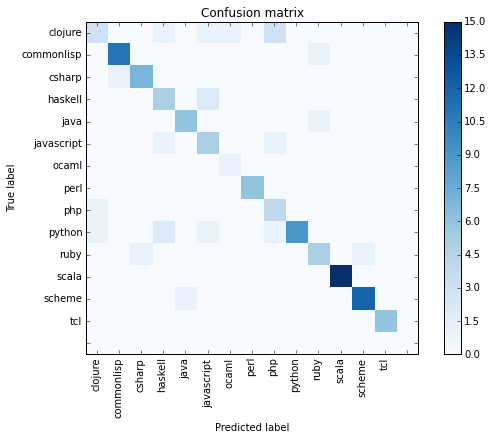

In [107]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
# classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6  # that's default image size for this interactive session

my_labels = classifier.classes_


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    fig, ax = plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()


    tick_marks = np.arange(len(classifier.classes_))
    plt.xticks(tick_marks, my_labels, rotation=90)
    plt.yticks(tick_marks, my_labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    from matplotlib.ticker import MultipleLocator # from http://stackoverflow.com/a/19252430 comments
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=my_labels)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#print('Normalized confusion matrix')
#print(cm_normalized)
#plt.figure()
#plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

#plt.show()
